In [108]:
from transformers import pipeline, AutoTokenizer, AutoModel
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import torch
import numpy as np
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datasets import ClassLabel
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [33]:
wines = load_dataset("GroNLP/ik-nlp-22_winemag")

In [34]:
wines

DatasetDict({
    train: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 70458
    })
    validation: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 5000
    })
})

In [35]:
print(wines["train"][42])

{'index': 59424, 'country': 'France', 'description': "A dense wine, with black fruits that go in one direction, and tannins that go in another. Maybe this is because it's young. There is some good, ripe acidity and blackberry flavors, so in six months, this may well integrate.", 'points': 85, 'price': 15.0, 'province': 'Bordeaux', 'variety': 'Bordeaux-style Red Blend'}


In [36]:
wines["train"].column_names

['index', 'country', 'description', 'points', 'price', 'province', 'variety']

In [37]:
print(wines["train"].features)

{'index': Value(dtype='int64', id=None), 'country': Value(dtype='string', id=None), 'description': Value(dtype='string', id=None), 'points': Value(dtype='int64', id=None), 'price': Value(dtype='float64', id=None), 'province': Value(dtype='string', id=None), 'variety': Value(dtype='string', id=None)}


We'll use the columnn "variety" as the label for our classifier. However, each entry is a string and not a ClassLabel. 

In [38]:
wines["train"] = wines["train"].class_encode_column("variety")
wines["test"] = wines["test"].class_encode_column("variety")
wines["validation"] = wines["validation"].class_encode_column("variety")


Casting to class labels:   0%|          | 0/5000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [39]:
print(wines["train"].features)

{'index': Value(dtype='int64', id=None), 'country': Value(dtype='string', id=None), 'description': Value(dtype='string', id=None), 'points': Value(dtype='int64', id=None), 'price': Value(dtype='float64', id=None), 'province': Value(dtype='string', id=None), 'variety': ClassLabel(names=['Barbera', 'Bordeaux-style Red Blend', 'Bordeaux-style White Blend', 'Cabernet Franc', 'Cabernet Sauvignon', 'Champagne Blend', 'Chardonnay', 'Gewürztraminer', 'Glera', 'Grenache', 'Malbec', 'Merlot', 'Nebbiolo', 'Petite Sirah', 'Pinot Grigio', 'Pinot Gris', 'Pinot Noir', 'Portuguese Red', 'Red Blend', 'Rhône-style Red Blend', 'Riesling', 'Rosé', 'Sangiovese', 'Sangiovese Grosso', 'Sauvignon Blanc', 'Sparkling Blend', 'Syrah', 'Tempranillo', 'Tempranillo Blend', 'Viognier', 'White Blend', 'Zinfandel'], id=None)}


In [40]:
wines.set_format(type="pandas")
df = wines["train"][:]
df.head()

,index,country,description,points,price,province,variety
0,129857,US,Dusty tannins make for a soft texture in this ...,90,44.0,California,11
1,112217,US,Sweet-tart Maraschino cherry and bitter brambl...,85,14.0,New York,16
2,114216,France,A lightly orange-colored rosé that is made by ...,92,90.0,Champagne,5
3,37808,France,"A ripe wine that is almost off dry, this has a...",85,17.0,Bordeaux,1
4,31157,US,"Crisp and very floral, this is a beautiful sho...",92,20.0,California,15


In [42]:
def label_int2str(row):
    return wines["train"].features["variety"].int2str(row)

df["variety_name"] = df["variety"].apply(label_int2str)


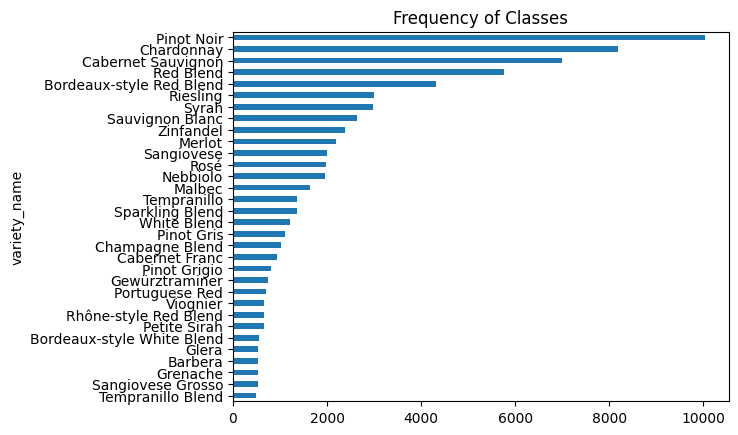

In [44]:
df["variety_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The classes are terribly unbalanced and significantly skewed towards Pinot Noir. While I'm impartial to a glass of Pinot, we will need to revisit this later. For now, let's cautiously proceed.

In [45]:
df["words per description"] = df["description"].str.split().apply(len)

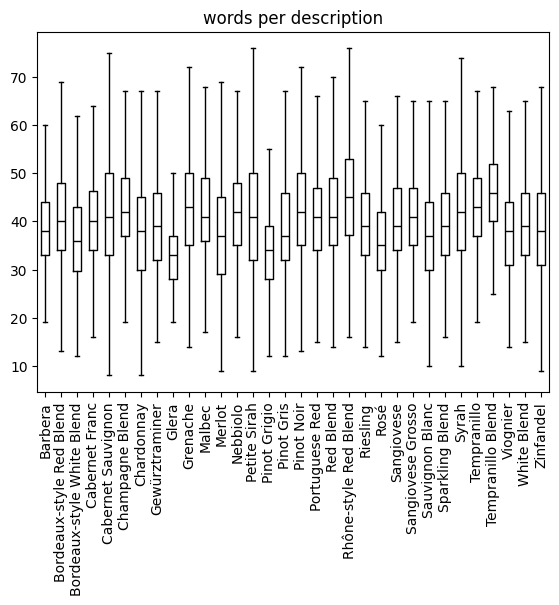

In [46]:
df.boxplot("words per description", by="variety_name", grid=False,
          showfliers=False, color="black", rot=90)
plt.suptitle("")
plt.xlabel("")
plt.show()

most descriptions tend to be around 40-45 words in length with the longest reviews being 80 words.

Before we go any further, we need to reset the output format as we no longer need to work with DataFrames.

In [47]:
wines.reset_format()

In [48]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/home/djh/Development/python/wine-classification/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [49]:
encoded_text = tokenizer(wines["train"][42]["description"])
print(encoded_text)

{'input_ids': [101, 1037, 9742, 4511, 1010, 2007, 2304, 10962, 2008, 2175, 1999, 2028, 3257, 1010, 1998, 9092, 11483, 2015, 2008, 2175, 1999, 2178, 1012, 2672, 2023, 2003, 2138, 2009, 1005, 1055, 2402, 1012, 2045, 2003, 2070, 2204, 1010, 22503, 5648, 3012, 1998, 25935, 26389, 1010, 2061, 1999, 2416, 2706, 1010, 2023, 2089, 2092, 17409, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [50]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'a', 'dense', 'wine', ',', 'with', 'black', 'fruits', 'that', 'go', 'in', 'one', 'direction', ',', 'and', 'tan', '##nin', '##s', 'that', 'go', 'in', 'another', '.', 'maybe', 'this', 'is', 'because', 'it', "'", 's', 'young', '.', 'there', 'is', 'some', 'good', ',', 'ripe', 'acid', '##ity', 'and', 'blackberry', 'flavors', ',', 'so', 'in', 'six', 'months', ',', 'this', 'may', 'well', 'integrate', '.', '[SEP]']


In [51]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] a dense wine, with black fruits that go in one direction, and tannins that go in another. maybe this is because it ' s young. there is some good, ripe acidity and blackberry flavors, so in six months, this may well integrate. [SEP]


In [52]:
tokenizer.vocab_size

30522

In [53]:
tokenizer.model_max_length

512

This is a small context length but should be more than amble for this use case given the maximum review size is about 80 words.

In [54]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

This should come as no surprise as we saw this earlier.

In [55]:
def tokenize(batch):
    return tokenizer(batch["description"], padding=True, truncation=True)

In [56]:
print(tokenize(wines["train"][:3]))

{'input_ids': [[101, 12727, 9092, 11483, 2015, 2191, 2005, 1037, 3730, 14902, 1999, 2023, 4511, 2008, 1005, 1055, 11259, 1999, 9550, 5909, 1010, 4234, 17688, 1010, 7967, 1998, 18856, 21818, 1012, 2009, 18058, 14894, 1998, 11619, 2302, 7729, 1010, 1037, 7842, 14550, 2100, 3670, 1997, 1996, 14722, 2013, 1037, 4659, 4658, 4785, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4086, 1011, 16985, 2102, 13955, 11624, 5740, 9115, 1998, 8618, 20839, 3468, 3964, 11463, 2094, 1999, 2023, 8595, 2100, 1010, 3078, 2417, 4511, 1012, 13675, 2319, 9766, 5648, 3012, 4978, 1996, 3054, 19636, 2618, 2007, 1037, 8560, 23690, 2486, 1998, 26577, 2015, 2083, 1037, 17844, 2146, 3926, 1012, 4392, 2085, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1037, 8217, 4589, 1011, 6910, 3123, 2008, 2003, 2081, 2011, 19382, 15172, 1996, 16575, 2006, 1996, 21049, 2005, 5824, 2847, 1012, 1996, 2765, 2003, 1037, 3730, 4511, 1010, 2200, 4318, 2096, 2036, 4760, 1037, 8352, 2839, 2008, 3957, 4138, 2791, 1012, 22503, 2417, 1

There are several zeros in the attention mask for the first two tokenized strings. This happens because the tokenised strings are shorter than the longest ```python wines["train"][2]``` and so they are padded with zeros.

In [57]:
wines_encoded = wines.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/70458 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [58]:
print(wines_encoded["train"].column_names)

['index', 'country', 'description', 'points', 'price', 'province', 'variety', 'input_ids', 'attention_mask']


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [60]:
text = "This tastes like red wine."
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 8])


In [61]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.0846, -0.0268,  0.0995,  ..., -0.2137,  0.2830,  0.2148],
         [ 0.0539,  0.0750,  0.1434,  ..., -0.2600,  0.4398,  0.2631],
         [ 0.0135,  0.2048,  0.3355,  ..., -0.4023,  0.0500,  0.0580],
         ...,
         [ 0.5952,  0.2765,  0.1802,  ..., -0.0500,  0.1669, -0.3235],
         [ 0.8180,  0.0557, -0.4205,  ..., -0.0975, -0.3562, -0.5558],
         [ 0.3269,  0.2218,  0.2999,  ..., -0.3759,  0.4464, -0.2071]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [62]:
outputs.last_hidden_state.size()

torch.Size([1, 8, 768])

In [63]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [64]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [65]:
wines_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "variety"])

In [66]:
wines_hidden = wines_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/70458 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [67]:
wines_hidden["train"].column_names

['index',
 'country',
 'description',
 'points',
 'price',
 'province',
 'variety',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [68]:
X_train = np.array(wines_hidden["train"]["hidden_state"])
X_valid = np.array(wines_hidden["validation"]["hidden_state"])
y_train = np.array(wines_hidden["train"]["variety"])
y_valid = np.array(wines_hidden["validation"]["variety"])
X_train.shape, X_valid.shape

((70458, 768), (5000, 768))

In [69]:
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["variety"] = y_train
df_emb.head()

,X,Y,variety
0,6.274401,-0.859734,11
1,5.136956,2.751262,16
2,4.791095,2.615562,5
3,4.031709,-2.256854,1
4,7.774029,0.902342,15


In [94]:
cmaps = list(colormaps)[:32]
print(cmaps)
print(len(cmaps))

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral']
32


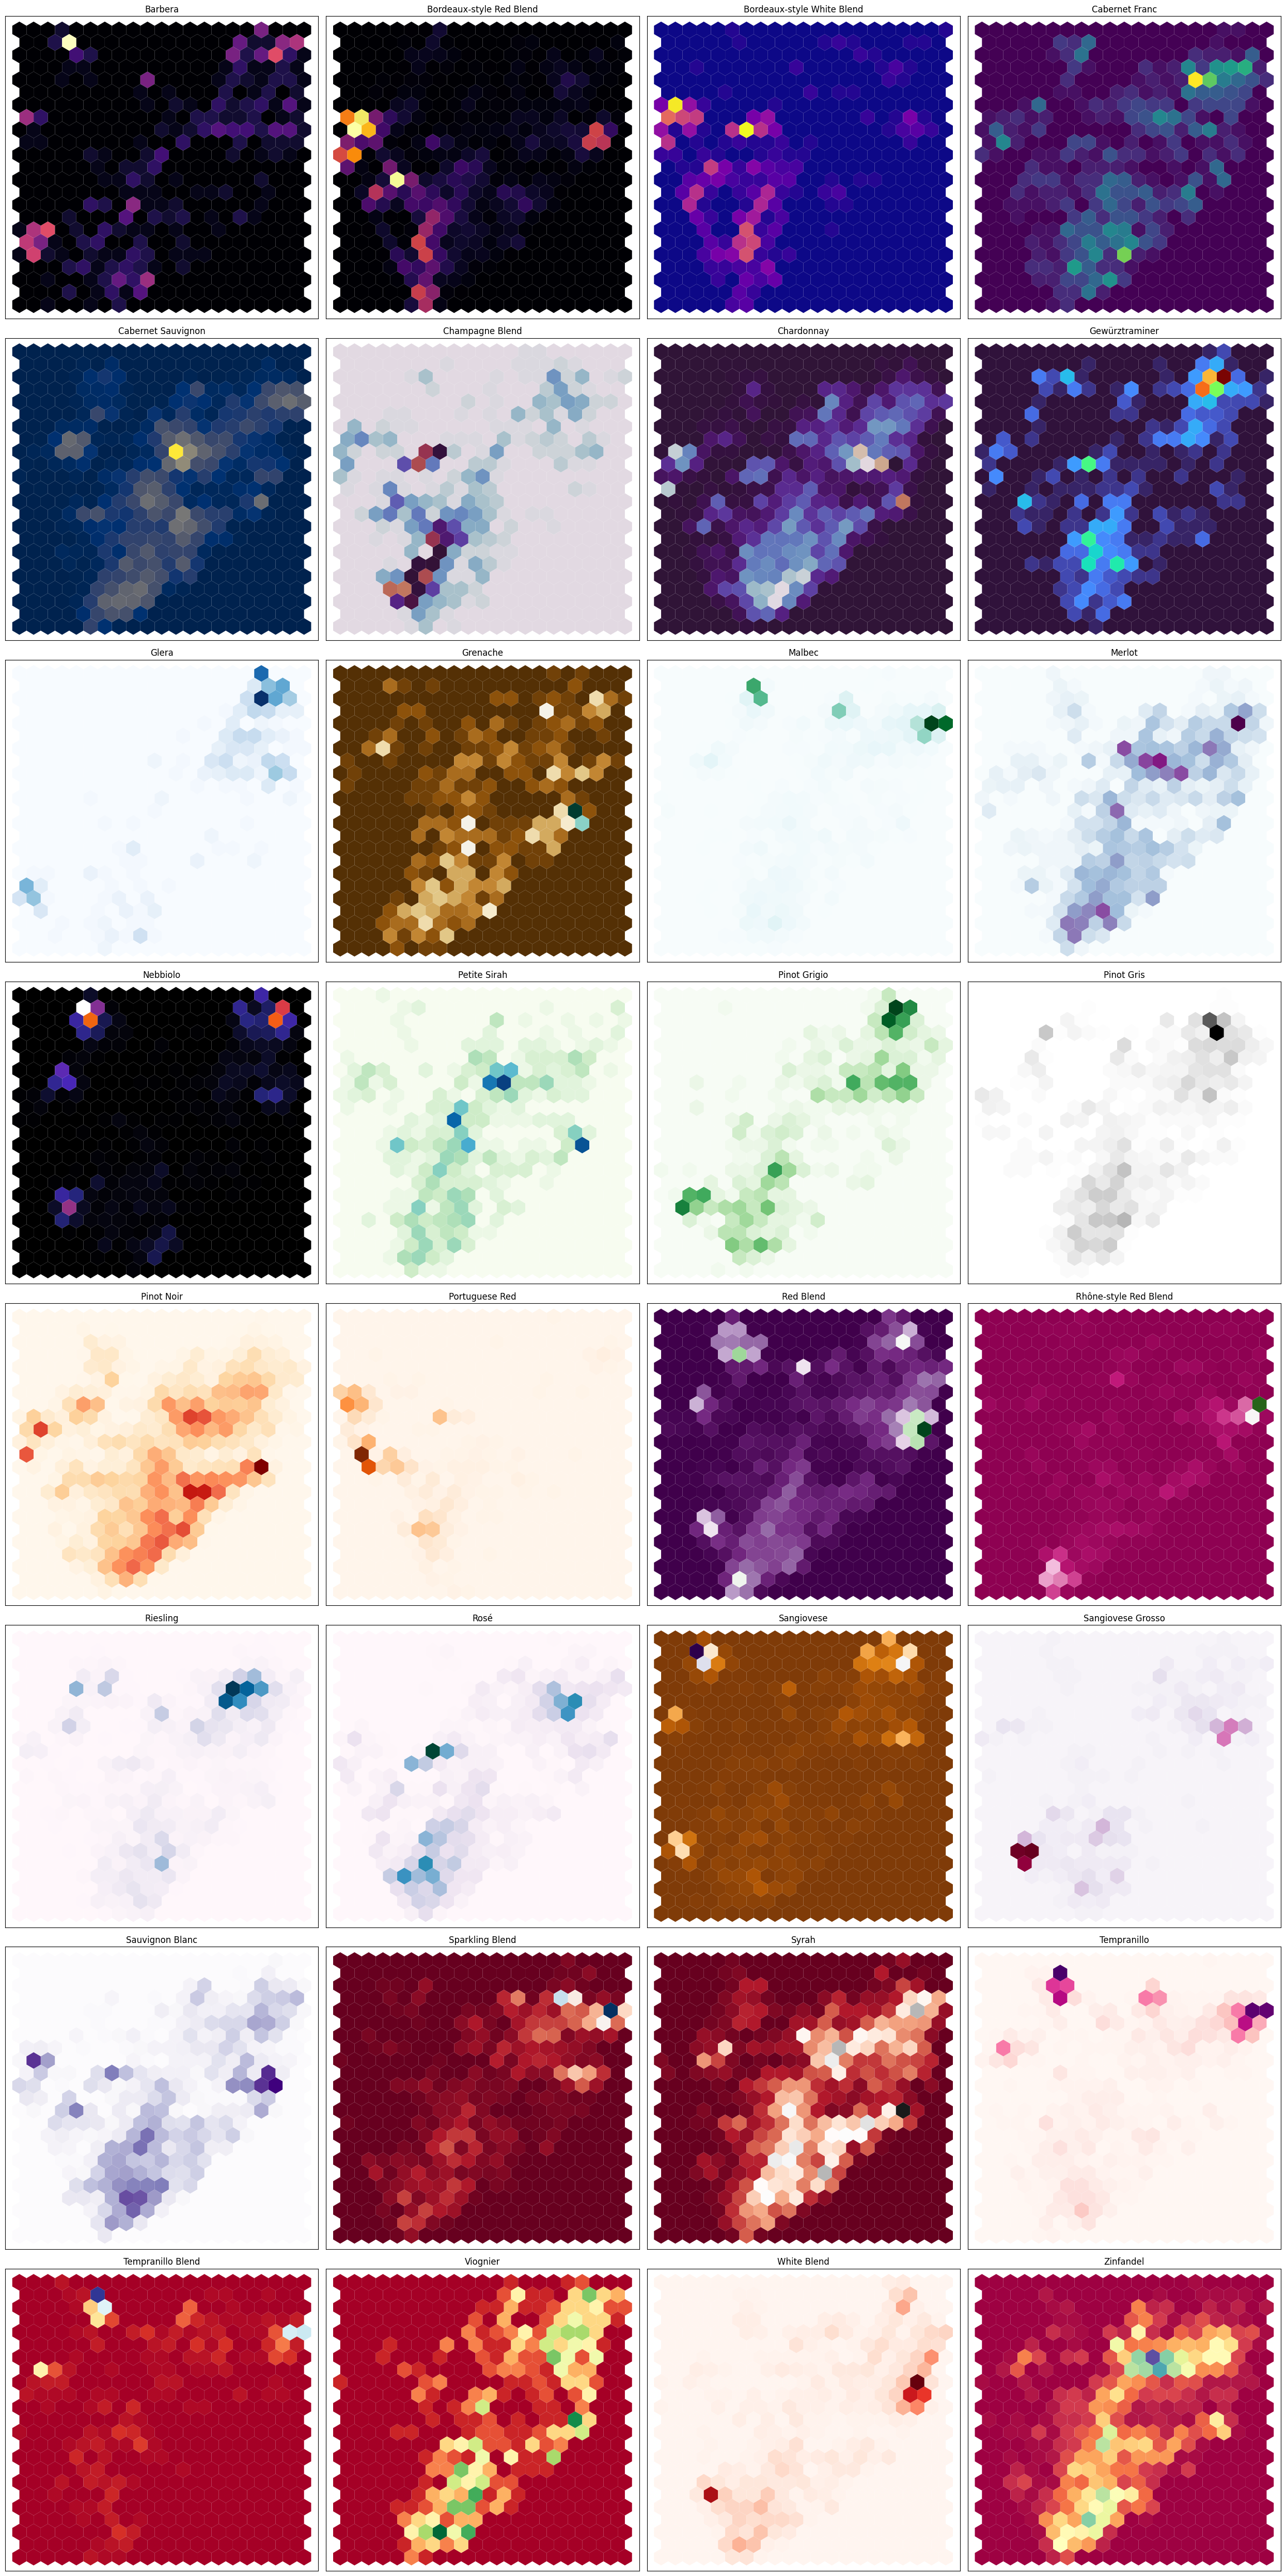

In [100]:
fig, axes = plt.subplots(8, 4, figsize=(25,50))
axes = axes.flatten()
cmaps = list(colormaps)[:32]
varieties = wines["train"].features["variety"].names

for i, (variety, cmap) in enumerate(zip(varieties, cmaps)):
    df_emb_sub = df_emb.query(f"variety == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(variety)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [105]:
#scikit learn doesn't appear to natively suppot a GPU????!!!
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

/home/djh/Development/python/wine-classification/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5776

This looks little better than random chance but as we saw earlier the distrubution is skewed. Let's see how much better than random chance it is.

In [107]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.14

This is much, much better than chance.

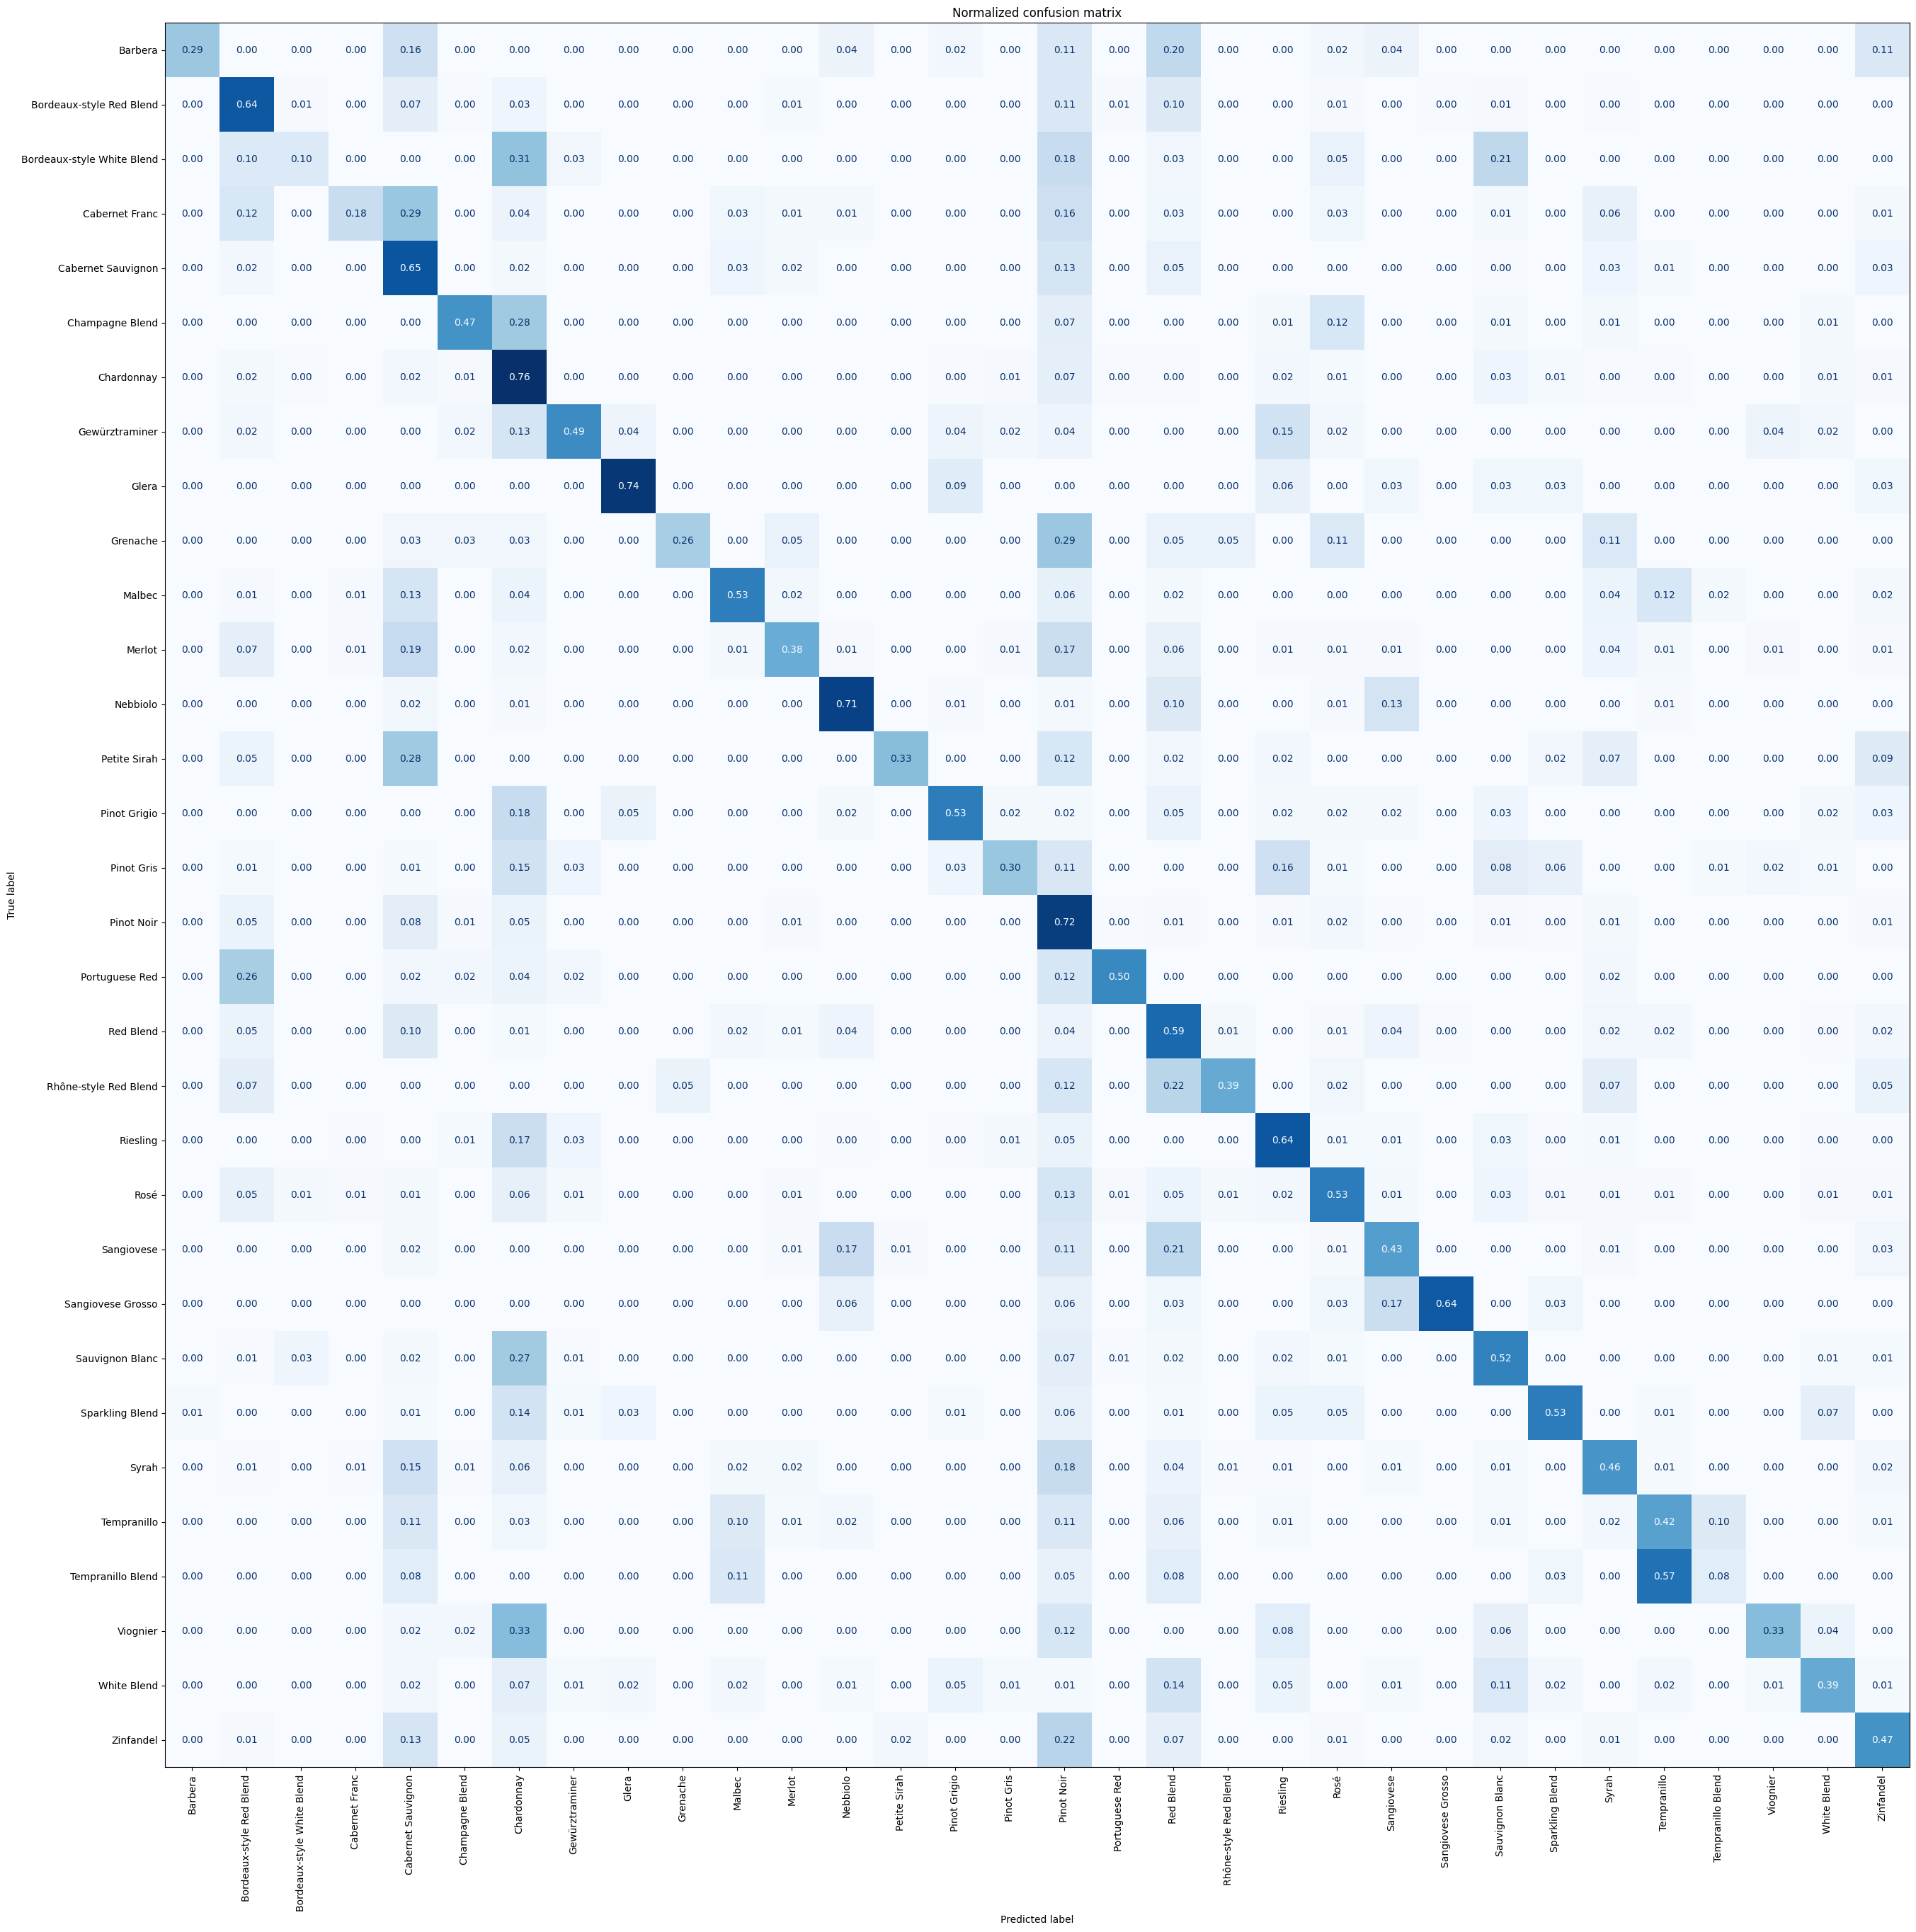

In [117]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(32, 32))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, varieties)